# XC - Tabular Data 
## Wine Quality - Anomaly Detection

___

### Task
Implement, train, and evaluate an anomaly detection algorithm for tabular data.

___

## 1. Data Preparation

* Download the dataset: https://archive.ics.uci.edu/static/public/186/wine+quality.zip*

Dataset loading

In [1]:
import pandas as pd

#Loading dataset

wine = pd.read_csv('../data/winequality.csv')

Rapid inspection

In [2]:

wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
wine = wine.dropna()

In [4]:
wine.shape

(6463, 13)

___

### Instructions

- Replace the values in the `quality` column of the test csv's with a flag indicating whether the wine quality is **GOOD**  or **BAD**.

- Re-split the data as if you have received 4 datasets:
    - White wine Train data: 90% of the GOOD white wine samples.
    - Red wine Train data: 90% of the GOOD red wine samples.
    - White wine Test data: The remainder of the GOOD and all BAD white wine samples.
    - Red wine Test data: The remainder of the GOOD and all BAD red wine samples.

- Save the re-split data as CSV files (for example: `white_wine_train.csv`, `red_wine_train.csv`, `white_wine_test.csv`, `red_wine_test.csv`)

#### Notes: 

- GOOD sample: a sample with a "quality" value of 5 or more.
- BAD sample: a sample with a "quality" value of 4 or less.
- The flag can be of any type you prefer (0/1, text, boolean, etc.).
You will use this column later to measure the accuracy of your algorithm.

___

Make bins & assign labels

In [5]:
from sklearn.preprocessing import LabelEncoder

bins = [0, 4, 10]
labels =  ['bad', 'good']
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = labels)
label_quality = LabelEncoder()
wine['quality'] = label_quality.fit_transform(wine['quality'])

Separate

In [6]:
red = wine[wine['type'] == 'red']
white = wine[wine['type'] == 'white']
red = red.drop("type", axis=1)
white = white.drop("type", axis=1)

In [7]:
red_good = red[red['quality'] == 1]
red_bad = red[red['quality'] == 0]
white_good = white[white['quality'] == 1]
white_bad = white[white['quality'] == 0]

Rapid inspection

In [8]:
print(f"Red good: {red_good.shape[0]} \nRed bad: {red_bad.shape[0]} \nWhite good: {white_good.shape[0]} \nWhite bad: {white_bad.shape[0]}")

Red good: 1531 
Red bad: 62 
White good: 4688 
White bad: 182


In [9]:
red_good.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4898,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,1
4899,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,1
4900,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,1


Split

In [10]:
from sklearn.model_selection import train_test_split

random_state = 42

red_train, red_good_remainder = train_test_split(
    red_good, test_size=0.1, random_state=random_state, stratify=red_good['quality'])

white_train, white_good_remainder = train_test_split(
    white_good, test_size=0.1, random_state=random_state, stratify=white_good['quality'])

Sanity check

In [11]:
print(f"Red train size: {red_train.shape[0]}, Red test size: {red_good_remainder.shape[0]} + {red_bad.shape[0]}")
print(f"White train size: {white_train.shape[0]}, White test size: {white_good_remainder.shape[0]} + {white_bad.shape[0]}")

Red train size: 1377, Red test size: 154 + 62
White train size: 4219, White test size: 469 + 182


Concatenate

In [12]:
red_test = pd.concat([red_good_remainder, red_bad], axis=0) 
white_test = pd.concat([white_good_remainder, white_bad], axis=0) 

Shuffle

In [13]:
for df in [red_train, red_test, white_train, white_test]:
    df = df.sample(frac=1).reset_index(drop=True)

Export

In [14]:
red_train.to_csv("../data/red_train.csv", index=False)
red_test.to_csv("../data/red_test.csv", index=False)
white_train.to_csv("../data/white_train.csv", index=False)
white_test.to_csv("../data/white_test.csv", index=False)

Loading utility

In [15]:
from sklearn.preprocessing import StandardScaler

def loader(data_path):
    """
    Load data from specified path.

    Args:
        data (str): file path
    
    Returns:
        (tuple): X (features), y (target variable), and column names (cols)
    """
    df = pd.read_csv(data_path)
    X = df.drop("quality", axis=1)
    y = df['quality']
    cols = list(df.columns)
    sc = StandardScaler()
    X = sc.fit_transform(X)
    return X, y, cols

## 2. Data Analysis

___

### Instructions

Explore the data to decide what kind of model can be used.

___

### Example: Red wine

In [16]:
train_set = "../data/red_train.csv"
X_train, y_train, _ = loader(train_set)

test_set = "../data/red_test.csv"
X_test, y_test, _ = loader(test_set)

#### Isolation Forest

The algorithm works by isolating each data point from the others, and the points that are isolated the most are considered anomalies.

In [17]:
from pyod.models.iforest import IForest
from pyod.utils.data import evaluate_print

iforest = IForest()
iforest.fit(X_train)

iforest_predictions = iforest.predict(X_test)  # outlier labels (0 or 1)
iforest_scores = iforest.decision_function(X_test)  # outlier scores

print("\nOn Test Data:")
evaluate_print('Isolation Forest', y_test, iforest_scores)

# example of the feature importance
feature_importance = iforest.feature_importances_
print("Feature importance", feature_importance)


On Test Data:
Isolation Forest ROC:0.4743, precision @ rank n:0.6948
Feature importance [0.08724413 0.09509668 0.08875983 0.09293059 0.09144327 0.0821832
 0.09458742 0.10157805 0.0836061  0.09014877 0.09242197]


In [18]:
iforest_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
# y_labels = (0, 1) # bad (outlier), good (inlier)
# sklearn_labels = (-1, 1) # outlier, inlier
# pyod_labels = (0, 1) # inlier, outlier

import numpy as np 

def recode(predictions, implementation):
    assert implementation in ['sklearn', 'pyod']
    if implementation == 'sklearn':
        l = lambda x: 1 if x == 1 else 0
    else:
        l = lambda x: 0 if x == 1 else 1
    return np.array(list(map(l, predictions)))

In [20]:
iforest_predictions = recode(iforest_predictions, 'pyod')
iforest_predictions

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [21]:
from sklearn.metrics import roc_auc_score

# calculate the AUC
iforest_auc = roc_auc_score(y_test, iforest_predictions)
print("AUC: ", iforest_auc)

AUC:  0.4916212819438626


In [22]:
from sklearn.metrics import f1_score

# calculate the F1-score
iforest_fscore = f1_score(y_test, iforest_predictions, average='macro')
print("F1 score: ", iforest_fscore)

F1 score:  0.4581184668989547


In [23]:
def prediction_df(predictions, scores):
    return pd.DataFrame({'prediction': predictions,
                        'score': scores
                        })

In [24]:
iforest_results = prediction_df(y_test, iforest_predictions)
iforest_results

,prediction,score
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
211,0,1
212,0,1
213,0,1
214,0,1


In [25]:
from sklearn.metrics import classification_report

def report_df(y, predictions):
    labels = [0, 1]
    report_dict = classification_report(y, predictions, output_dict=True)
    output_df = pd.DataFrame(report_dict).round(2).transpose()
    output_df.insert(loc=0, column='class', value=labels + ["accuracy", "macro avg", "weighted avg"])
    #output.to_csv(export_path, index=False)
    return output_df

In [26]:
iforest_report = report_df(y_test, iforest_predictions)
iforest_report

,class,precision,recall,f1-score,support
0,0,0.25,0.08,0.12,62.00
1,1,0.71,0.90,0.79,154.00
accuracy,accuracy,0.67,0.67,0.67,0.67
macro avg,macro avg,0.48,0.49,0.46,216.00
weighted avg,weighted avg,0.58,0.67,0.60,216.00


In [27]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cmatrix(y, predictions):
    conf_matrix = confusion_matrix(y, predictions)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns_plot = sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    fig = sns_plot.figure
    #plt.savefig(export_path)
    return fig

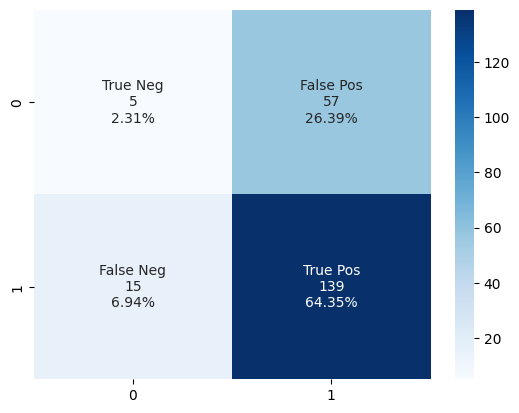

In [28]:
f = plot_cmatrix(y_test, iforest_predictions)

#### K-Nearest Neighbors (KNN)

KNN calculates the distance to the k-nearest neighbors and identifies points with high distance as anomalies.

In [29]:
from pyod.models.knn import KNN  

knn = KNN()
knn.fit(X_train)

# get the prediction on the test data
knn_predictions = knn.predict(X_test)  # outlier labels (0 or 1)
knn_scores = knn.decision_function(X_test)  # outlier scores

# it is possible to get the prediction confidence as well
knn_predictions, knn_confidence = knn.predict(X_test, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]

print("\nOn Test Data:")
evaluate_print('KNN', y_test, knn_scores)


On Test Data:
KNN ROC:0.4478, precision @ rank n:0.6948


#### Empirical Cumulative Distribution-based Outlier Detection (ECOD)

ECOD is a non-parametric method that uses canonical correlation analysis (CCA) to learn a low-dimensional representation of the data. The method is based on the idea of finding a linear transformation that maximizes the correlation between the original data and its low-dimensional representation.


In [30]:
from pyod.models.ecod import ECOD

ecod = ECOD()
ecod.fit(X_train)

# get the prediction on the test data
ecod_predictions = ecod.predict(X_test)  # outlier labels (0 or 1)
ecod_scores = ecod.decision_function(X_test)  # outlier scores

print("\nOn Test Data:")
evaluate_print("ECOD", y_test, ecod_scores)


On Test Data:
ECOD ROC:0.4069, precision @ rank n:0.6883


#### Autoencoder

An autoencoder learns a mapping from the input space to a lower-dimensional space and back to the input space, and identifies points that are not well-represented in the lower-dimensional space as anomalies.

In [31]:
from pyod.models.auto_encoder import AutoEncoder


autoencoder = AutoEncoder(epoch_num=30, contamination=0.00001)
autoencoder.fit(X_train)

# get the prediction on the test data
autoencoder_pred = autoencoder.predict(X_test)  # outlier labels (0 or 1)
autoencoder_scores = autoencoder.decision_function(X_test)  # outlier scores

print("\nOn Test Data:")
evaluate_print('Autoencoder', y_test, autoencoder_scores)

Training: 100%|██████████| 30/30 [00:01<00:00, 18.58it/s]



On Test Data:
Autoencoder ROC:0.4468, precision @ rank n:0.7013


## 3. Python Package Implementation

<span style="color:teal">IMPLEMENTED IN `xctab`, IN THE ROOT FOLDER.</span>
___

### Instructions

Your package should contain:

- A train function that receives the training data in the appropriate format[3], along with the training configuration, trains the algorithm, and saves the trained parameters.

- A predict function that receives one or more samples and returns their quality (GOOD or BAD) and the probability (or likelihood, or score, or distance) associated.

- An inference function that receives the testing data in the appropriate format[3], predicts the results, computes, and saves the accuracy statistics (e.g., individual results, confusion matrix, Fscore, etc. - You may judge what is necessary).

- A CLI interface is welcome but not necessary.

- Prepare a short README with installation instructions and usage guide.


#### Notes:
- The input format may be a Pandas DataFrame, NumPy array, or another format you find suitable.

- DO NOT use the quality values for prediction. They should just serve as ground truth to evaluate the results.

- Use the output of the inference function to make your report.

- Consider that your package could be used for different datasets; the wine dataset is just an example use case.

___